Enter start date (YYYY-MM-DD): 2021-01-01
Enter end date (YYYY-MM-DD): 2022-01-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data saved to RELIANCE_data.csv
Data saved to TCS_data.csv
Data saved to HDFCBANK_data.csv
Data saved to INFY_data.csv


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - close_output_loss: 0.1882 - loss: 0.2225 - volume_output_loss: 0.0341
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - close_output_loss: 0.0988 - loss: 0.1130 - volume_output_loss: 0.0156
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - close_output_loss: 0.0953 - loss: 0.1129 - volume_output_loss: 0.0181
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - close_output_loss: 0.0810 - loss: 0.0975 - volume_output_loss: 0.0162
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - close_output_loss: 0.0836 - loss: 0.0937 - volume_output_loss: 0.0096
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - close_output_loss: 0.0723 - loss: 0.0930 - volume_output_loss: 0.0209
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - close_output_loss: 0.0769 - loss: 0.0885 - volume_output_loss: 0.0116
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - close_output_loss: 0.0757 - loss: 0.0863 - volume_output_loss: 0.0111
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━

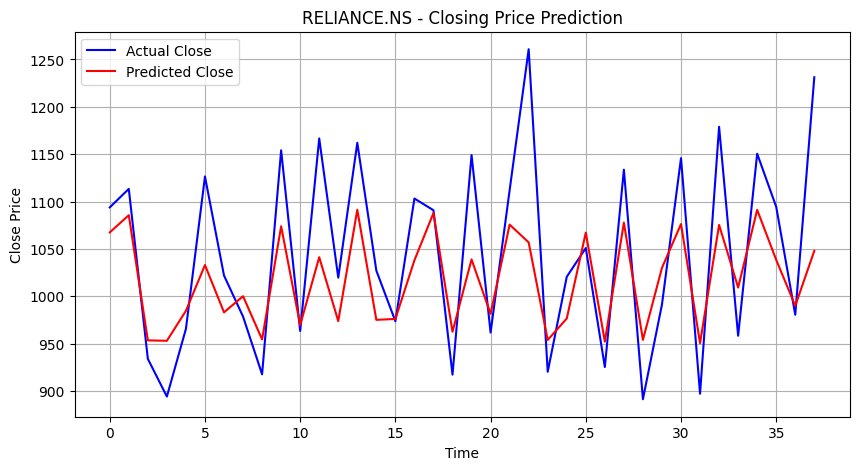

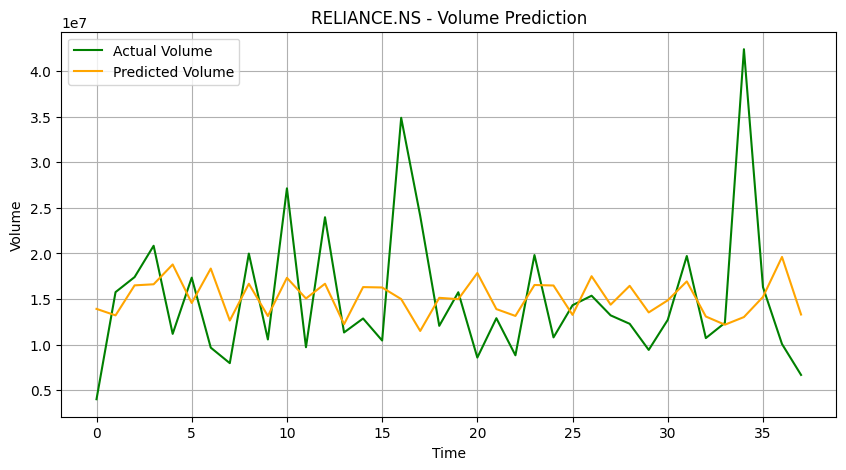

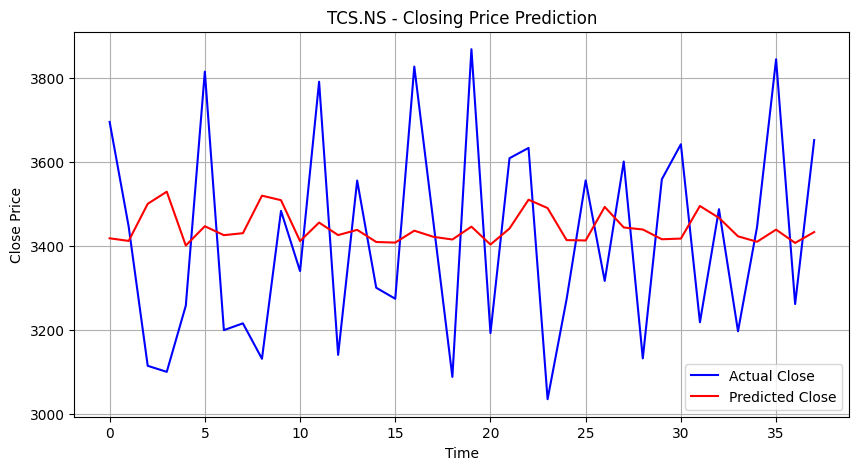

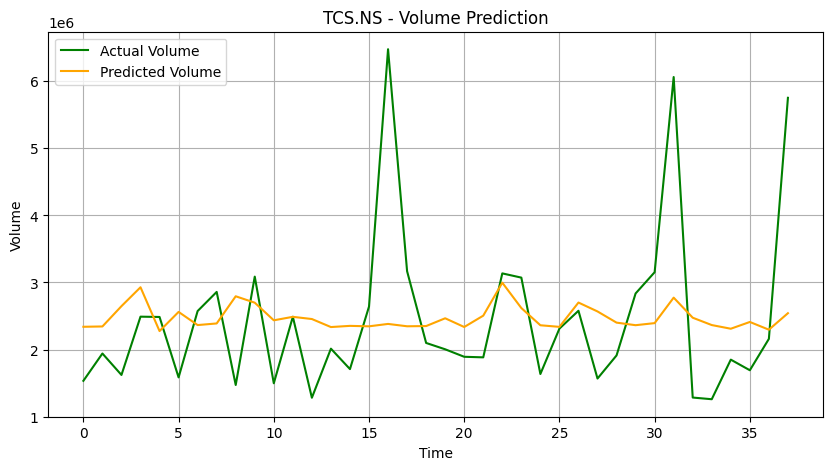

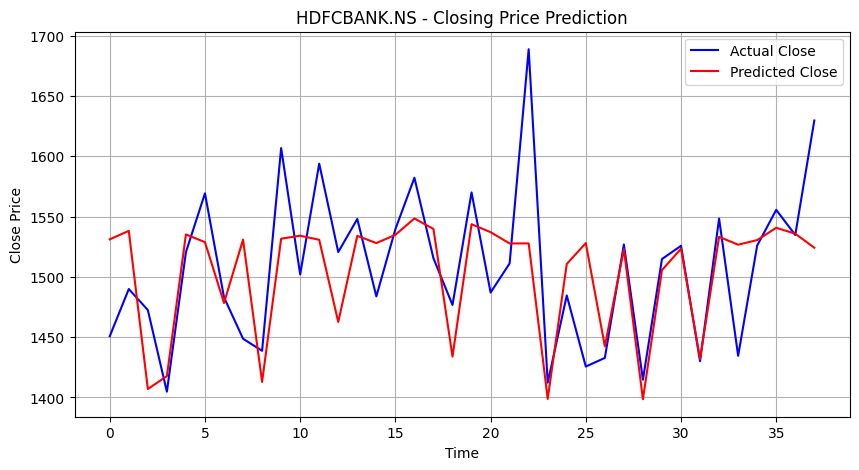

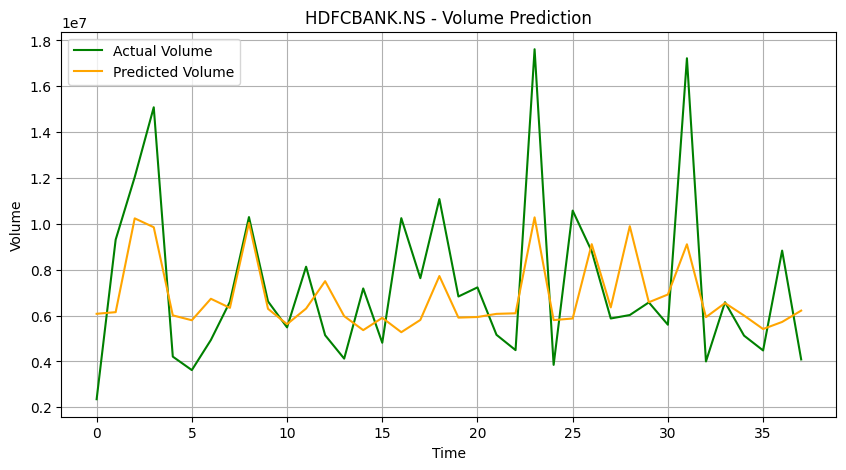

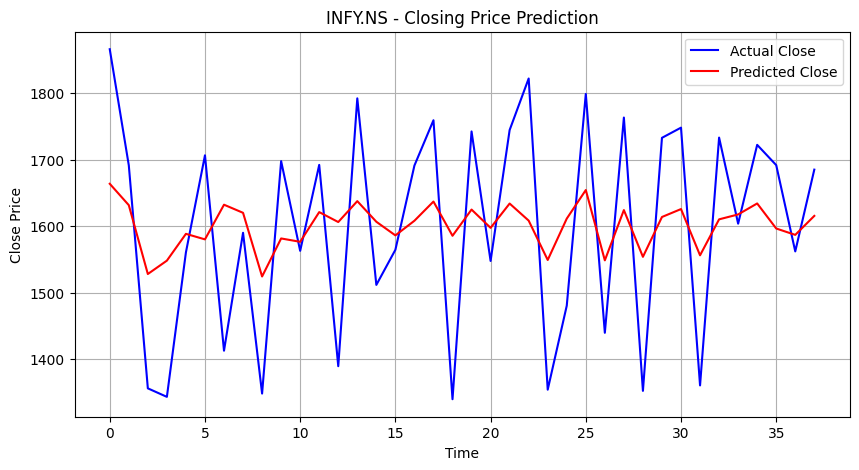

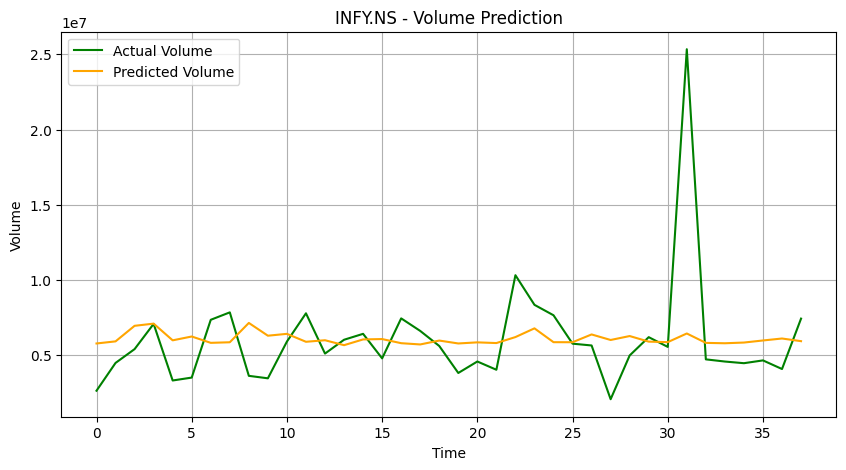

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Input, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of Sensex tickers
sensex_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS"]

# Input for date range
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

# Function to download stock data
def download_data(ticker):
    print(f'Downloading data for {ticker}')
    data = yf.download(ticker, start=start_date, end=end_date)
    if not data.empty:
        filename = f"{ticker.replace('.NS', '')}_data.csv"
        data.to_csv(filename)
        print(f'Data saved to {filename}')
        return data
    else:
        print(f'No data available for {ticker}')
        return None

# Download data for all tickers
stock_data = {}
for ticker in sensex_tickers:
    data = download_data(ticker)
    if data is not None:
        stock_data[ticker] = data

# Data preprocessing function
def preprocess_data(data, look_back=60):
    scaler_close = MinMaxScaler(feature_range=(0, 1))
    scaler_volume = MinMaxScaler(feature_range=(0, 1))

    scaled_close = scaler_close.fit_transform(data[['Close']])
    scaled_volume = scaler_volume.fit_transform(data[['Volume']])

    X, y_close, y_volume = [], [], []
    for i in range(look_back, len(scaled_close)):
        X.append(np.hstack([scaled_close[i-look_back:i, 0], scaled_volume[i-look_back:i, 0]]))
        y_close.append(scaled_close[i, 0])
        y_volume.append(scaled_volume[i, 0])

    X, y_close, y_volume = np.array(X), np.array(y_close), np.array(y_volume)
    X = np.reshape(X, (X.shape[0], look_back, 2))

    return X, y_close, y_volume, scaler_close, scaler_volume

# Preprocess all stocks data
preprocessed_data = {}
for ticker, data in stock_data.items():
    X, y_close, y_volume, scaler_close, scaler_volume = preprocess_data(data)
    preprocessed_data[ticker] = (X, y_close, y_volume, scaler_close, scaler_volume)

# Build the hybrid model
def build_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)

    # LSTM layer
    x = LSTM(50, return_sequences=False)(x)

    # Output layers
    close_output = Dense(1, name='close_output')(x)
    volume_output = Dense(1, name='volume_output')(x)

    model = Model(inputs=inputs, outputs=[close_output, volume_output])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Directional Accuracy
    direction_actual = np.sign(np.diff(actual.flatten()))
    direction_predicted = np.sign(np.diff(predicted.flatten()))
    directional_accuracy = np.mean(direction_actual == direction_predicted) * 100

    return mae, mse, rmse, r2, directional_accuracy

# Function to train and predict
def train_and_predict(ticker, X, y_close, y_volume, scaler_close, scaler_volume, epochs=20, batch_size=32):
    # Train/test split
    X_train, X_test, y_close_train, y_close_test, y_volume_train, y_volume_test = train_test_split(
        X, y_close, y_volume, test_size=0.2, random_state=42
    )

    # Build and train the model
    model = build_hybrid_model(X_train.shape[1:])
    model.fit(X_train, [y_close_train, y_volume_train], epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions
    y_close_pred, y_volume_pred = model.predict(X_test)
    y_close_pred = scaler_close.inverse_transform(y_close_pred)
    y_volume_pred = scaler_volume.inverse_transform(y_volume_pred)

    actual_close = scaler_close.inverse_transform(y_close_test.reshape(-1, 1))
    actual_volume = scaler_volume.inverse_transform(y_volume_test.reshape(-1, 1))

    # Save predictions and actual data to CSV
    result_df = pd.DataFrame({
        'Actual_Close': actual_close.flatten(),
        'Predicted_Close': y_close_pred.flatten(),
        'Actual_Volume': actual_volume.flatten(),
        'Predicted_Volume': y_volume_pred.flatten()
    })
    result_filename = f"{ticker.replace('.NS', '')}_predictions.csv"
    result_df.to_csv(result_filename, index=False)
    print(f'Predictions saved to {result_filename}')

    # Calculate metrics
    close_metrics = calculate_metrics(actual_close, y_close_pred)
    volume_metrics = calculate_metrics(actual_volume, y_volume_pred)

    print(f"\nMetrics for {ticker} (Closing Price):")
    print(f"MAE: {close_metrics[0]:.2f}, MSE: {close_metrics[1]:.2f}, RMSE: {close_metrics[2]:.2f}, R²: {close_metrics[3]:.2f}, DA: {close_metrics[4]:.2f}%")

    print(f"\nMetrics for {ticker} (Volume):")
    print(f"MAE: {volume_metrics[0]:.2f}, MSE: {volume_metrics[1]:.2f}, RMSE: {volume_metrics[2]:.2f}, R²: {volume_metrics[3]:.2f}, DA: {volume_metrics[4]:.2f}%")

    return result_df

# Train and predict for all tickers
results = {}
for ticker, (X, y_close, y_volume, scaler_close, scaler_volume) in preprocessed_data.items():
    results[ticker] = train_and_predict(ticker, X, y_close, y_volume, scaler_close, scaler_volume)

# Function to plot predictions
def plot_predictions(ticker, result_df):
    # Plot for Close predictions
    plt.figure(figsize=(10, 5))
    plt.plot(result_df['Actual_Close'], label='Actual Close', color='blue')
    plt.plot(result_df['Predicted_Close'], label='Predicted Close', color='red')
    plt.title(f"{ticker} - Closing Price Prediction")
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot for Volume predictions
    plt.figure(figsize=(10, 5))
    plt.plot(result_df['Actual_Volume'], label='Actual Volume', color='green')
    plt.plot(result_df['Predicted_Volume'], label='Predicted Volume', color='orange')
    plt.title(f"{ticker} - Volume Prediction")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid()
    plt.show()

# Plot predictions for all tickers
for ticker, result_df in results.items():
    plot_predictions(ticker, result_df)
